<a href="https://colab.research.google.com/github/curieuxjy/deep-learning-from-scratch-5/blob/main/step04/ch4_gmm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **가우스 혼합 모델 (GMM)**  
- 정규 분포는 단일한 확률 분포를 나타내지만, 현실에서는 여러 개의 정규 분포가 혼합된 형태로 나타나는 경우가 많음.  
- 이러한 혼합된 분포를 표현하는 방법이 **가우스 혼합 모델(GMM, Gaussian Mixture Model)**.  
- GMM은 여러 개의 개별 정규 분포를 조합하여 복잡한 데이터 분포를 모델링
---

### **4.1.1 다봉 분포 데이터셋**

- **간헐천 분출 데이터를 파이썬에서 불러와 분석**
- 데이터는 **`step04/old_faithful.txt` 파일**에 저장되어 있음.  


**간헐천 분출과 다중 분포**  
- **간헐천(Geyser)** 은 일정한 주기로 뜨거운 물을 분출하는 온천을 의미함.  
- 미국 **옐로스톤 국립공원에 위치한 ‘올드 페이스풀 간헐천(The Old Faithful Geyser)’** 은 대표적인 간헐천 중 하나.  
- 이 간헐천의 분출 패턴을 분석하면 **다중 분포를 보이는 경향**이 있음.  


- 연구된 272개의 데이터를 기반으로 한 산점도 분석에서,  
  - **가로축:** 분출 지속 시간 (1분 30초~5분)  
  - **세로축:** 분출 간격 (50~90분)  
- 데이터를 보면 **분출 시간이 길수록 다음 분출까지의 간격도 길어지는 경향**을 보이며,  
  - **이러한 패턴 역시 다중 분포의 특성을 가짐.**

---

In [2]:
!wget -O old_faithful.txt https://raw.githubusercontent.com/curieuxjy/deep-learning-from-scratch-5/main/step04/old_faithful.txt

# 파일 내용 확인
# with open("old_faithful.txt", "r") as file:
#     print(file.read()[:500])  # 처음 500자만 출력하여 확인

--2025-03-07 23:37:21--  https://raw.githubusercontent.com/curieuxjy/deep-learning-from-scratch-5/main/step04/old_faithful.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2253 (2.2K) [text/plain]
Saving to: ‘old_faithful.txt’

old_faithful.txt    100%[===================>]   2.20K  --.-KB/s    in 0s      

2025-03-07 23:37:21 (27.2 MB/s) - ‘old_faithful.txt’ saved [2253/2253]



In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

path = '/content/old_faithful.txt'
xs = np.loadtxt(path)

print(xs.shape)
print(xs[0])

(272, 2)
[ 3.6 79. ]


- 데이터는 **272개의 2차원 배열(`np.ndarray` 형식)** 로, 각 항목은  
  - **첫 번째 값:** 분출 지속 시간 (예: 3.6분)  
  - **두 번째 값:** 다음 분출까지의 간격 (예: 79분)  
- 이를 통해 **간헐천의 분출 패턴을 시각화하는 작업 진행**.

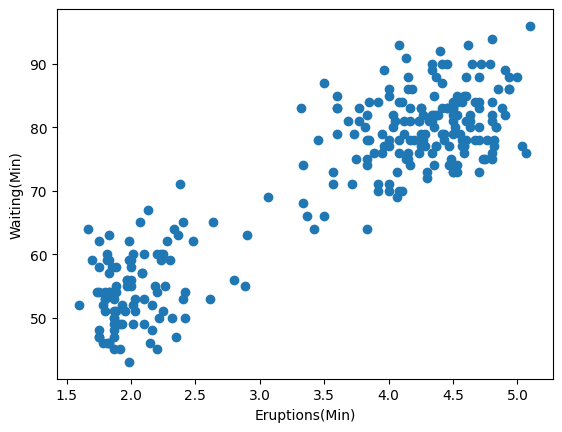

In [4]:
plt.scatter(xs[:,0], xs[:,1])
plt.xlabel('Eruptions(Min)')
plt.ylabel('Waiting(Min)')
plt.show()

---

## 4.2 가우스 혼합 모델 데이터 생성

- **다중 분포는 여러 개의 정규 분포가 혼합된 형태**로 나타나며, 이를 표현하는 방법이 **가우스 혼합 모델(GMM, Gaussian Mixture Model)**.  
- 목표: **GMM을 이용한 데이터 생성 모델을 구축**하는 것.  
- 이를 위해 두 가지 작업이 필요함:  
  1. **모델링:** 관측된 데이터 분포가 GMM으로 표현될 수 있다고 가정.  
  2. **매개변수 추정:** GMM의 매개변수를 학습하여 추정.  

- **매개변수 추정 후 학습된 GMM을 활용하여 새로운 데이터 생성 가능**.  
- GMM의 매개변수 추정은 어려운 작업이며, **최대 가능도 추정과 EM 알고리즘을 사용해야 함**.

---

### **4.2.1 GMM을 따르는 데이터 생성**

**GMM을 이용한 데이터 생성 절차**  

1. **두 개의 정규 분포를 준비**.  
2. **반복 과정:**  
   - **① 확률 분포를 따라 두 개의 정규 분포 중 하나를 선택**.  
   - **② 선택한 정규 분포에서 데이터를 샘플링하여 생성**.  
3. 이 과정을 반복하면 **GMM을 따르는 데이터 샘플을 얻을 수 있음**.

---

### **4.2.2 데이터 생성 코드**


In [6]:
# 필요한 라이브러리 임포트
import numpy as np
import matplotlib.pyplot as plt


# 두 정규분포의 평균 벡터 설정
# 첫 번째 분포: [2.0, 54.50], 두 번째 분포: [4.3, 80.0]
mus = np.array([[2.0, 54.50],
                [4.3, 80.0]])

# 두 정규분포의 공분산 행렬 설정
# 각 분포마다 2x2 공분산 행렬 정의
covs = np.array([[[0.07, 0.44],
                  [0.44, 33.7]],
                 [[0.17, 0.94],
                  [0.94, 36.00 ]]])

# 각 정규분포가 선택될 확률 설정
# 첫 번째 분포: 35%, 두 번째 분포: 65%
phis = np.array([0.35, 0.65])


def sample():
    # 지정된 확률에 따라 두 정규분포 중 하나를 무작위로 선택
    k = np.random.choice(2, p=phis)  # k는 0, 1 중에서 선택
    # 선택된 분포의 평균과 공분산 추출
    mu, cov = mus[k], covs[k]
    # 선택된 정규분포로부터 데이터 샘플링
    x = np.random.multivariate_normal(mu, cov)
    return x

1. **정규 분포의 매개변수 설정**  
   - 평균 벡터: `mus`  
   - 공분산 행렬: `covs`  
   - 예: `mus[0]`, `covs[0]` → 첫 번째 정규 분포의 매개변수  

2. **정규 분포 선택 확률 (`phis`) 설정**  
   - 예: `[0.35, 0.65]` →  
     - 첫 번째 정규 분포 선택 확률: 35%  
     - 두 번째 정규 분포 선택 확률: 65%  

3. **샘플링 과정**  
   - `np.random.choice(2, p=phis)`: 지정된 확률(`phis`)에 따라 두 정규 분포 중 하나를 선택  
   - `np.random.multivariate_normal(mu, cov)`: 선택한 정규 분포에서 데이터 샘플링  

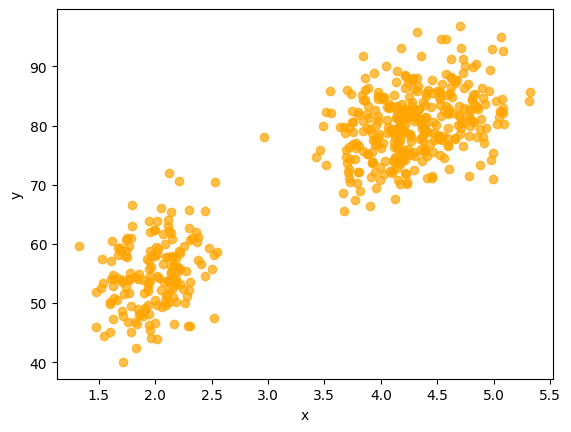

In [7]:
# 500개의 샘플 생성
N = 500
xs = np.zeros((N, 2))
for i in range(N):
     xs[i] = sample()

# 생성된 샘플을 산점도로 시각화
plt.scatter(xs[:,0], xs[:,1], color='orange', alpha=0.7)  # alpha=0.7로 투명도 설정
plt.xlabel('x')  # x축 레이블
plt.ylabel('y')  # y축 레이블
plt.show()  # 그래프 출력

4. **데이터 생성 및 시각화**  
   - `sample()` 함수를 사용해 **500개 샘플 추출 및 산점도 시각화**.

---   

## **4.3 가우스 혼합 모델(GMM)의 수식**  

주변화(marginalization)를 할 때 두 가지 방법이 있습니다:

1. **결합 확률 직접 사용**: `p(x) = ∫ p(x,y) dy`
2. **곱셈 정리 사용**: `p(x) = ∫ p(x|y)p(y) dy`

두 방법은 수학적으로 동일하지만, **곱셈 정리를 사용하는 것이 선호되는 이유**는:
- 조건부 확률이 결합 확률보다 구하기 쉬움
- 원인-결과 관계를 직관적으로 모델링 가능
- 복잡한 문제를 더 작은 부분으로 분해 가능

예를 들어 GMM에서는 `p(x) = Σ φₖ N(x; μₖ, Σₖ)`와 같이 클러스터 선택 확률과 정규분포를 독립적으로 모델링할 수 있습니다.


---

### **4.3.2 GMM 수식**  

**GMM 데이터 생성 절차:**  
  1. **$ K $ 개의 정규 분포를 준비**  
  2. 반복 과정:  
    - **① 특정 확률 분포를 따라 $ K $ 개의 정규 분포 중 하나를 선택**  
    - **② 선택한 정규 분포에서 데이터 생성**  

- ①번 과정은 여러 후보 중 하나를 선택하는 과정이며, **범주형 분포(Categorical Distribution)** 로 표현됨.  


**범주형 분포 (Categorical Distribution)**  
- 확률 변수 **$ z $** 는 **이산 확률 변수**로, $ K $ 개의 정수 값 중 하나를 가짐.  
- 범주형 분포의 매개변수 **$ \phi $** (파이)는 각 클래스가 선택될 확률을 의미함.  
- 수식 표현:  

  $  p(z = k; \phi) = \phi_k  $
- 여기서 **$ \phi_k $ 는 $ k $ 번째 정규 분포가 선택될 확률**

>**범주형 분포의 제약 조건**  
>
>- 모든 확률은 0 이상: $ \phi_k \geq 0 $
> - 전체 확률의 합은 1: $ \sum_{k=1}^{K} \phi_k = 1 $

**GMM의 정규 분포 표현**  
- $ K $ 개의 정규 분포를 매개변수로 설정:  

  $
  \mu = \{ \mu_1, \mu_2, \dots, \mu_K \}
  $

  $
  \Sigma = \{ \Sigma_1, \Sigma_2, \dots, \Sigma_K \}
  $
  - 여기서 **$ \mu_k $ 는 $ k $ 번째 정규 분포의 평균 벡터**,  
  - **$ \Sigma_k $ 는 공분산 행렬**을 의미.  

**최종 GMM의 확률 밀도 함수 (PDF)**  

  $ p(x) = \sum_{k=1}^{K} \phi_k N(x; \mu_k, \Sigma_k)  $ [식 4.3]

  👉 **각 정규 분포의 가중합(weighted sum)으로 표현됨**.  
  👉 $ \phi_k $ 는 각 정규 분포의 선택 확률.  

>**GMM의 잠재 변수 (Latent Variable) 개념**  
>- **$ z $** 는 GMM에서의 **잠재 변수(Latent Variable)**  
>  - 학습 과정에서는 사용되지만, 실제 관측 데이터에는 존재하지 않음.  
>  - 따라서, **관측되지 않은 변수(latent variable)로 처리**.  

👉 **즉, GMM은 여러 개의 정규 분포를 확률적으로 선택하여 데이터를 생성하는 혼합 모델(Mixture Model)이며, 그 확률 밀도 함수는 정규 분포의 가중합 형태로 표현됨.**

---

### **4.3.3 GMM 구현**

In [8]:
import numpy as np
import matplotlib.pyplot as plt


# 각 가우시안 분포의 평균값 (2차원)
mus = np.array([[2.0, 54.50],  # 첫 번째 가우시안의 평균
                [4.3, 80.0]])   # 두 번째 가우시안의 평균

# 각 가우시안 분포의 공분산 행렬 (2x2 행렬)
covs = np.array([[[0.07, 0.44],  # 첫 번째 가우시안의 공분산
                  [0.44, 33.7]],
                 [[0.17, 0.94],   # 두 번째 가우시안의 공분산
                  [0.94, 36.00 ]]])

# 각 가우시안의 혼합 계수 (가중치)
phis = np.array([0.35, 0.65])  # 합이 1이 되어야 함


def multivariate_normal(x, mu, cov):
    """다변수 정규분포의 확률밀도함수를 계산

    Args:
        x: 입력 데이터 (d차원 벡터)
        mu: 평균 벡터 (d차원)
        cov: 공분산 행렬 (d x d)

    Returns:
        y: x에서의 확률밀도값
    """
    det = np.linalg.det(cov)  # 공분산 행렬의 행렬식
    inv = np.linalg.inv(cov)  # 공분산 행렬의 역행렬
    d = len(x)  # 데이터 차원
    z = 1 / np.sqrt((2 * np.pi) ** d * det)  # 정규화 상수
    y = z * np.exp((x - mu).T @ inv @ (x - mu) / -2.0)  # 지수항 계산 [식 3.1]
    return y

def gmm(x, phis, mus, covs):
    """가우시안 혼합 모델의 확률밀도함수를 계산

    Args:
        x: 입력 데이터
        phis: 각 가우시안의 혼합 계수
        mus: 각 가우시안의 평균
        covs: 각 가우시안의 공분산

    Returns:
        y: x에서의 혼합 확률밀도값
    """
    K = len(phis)  # 가우시안 컴포넌트의 개수
    y = 0
    for k in range(K):
        phi, mu, cov = phis[k], mus[k], covs[k]
        y += phi * multivariate_normal(x, mu, cov)  # ① 정규 분포의 가중 합 계산
    return y

- **`gmm()` 함수에서 중요한 부분은 추출된 매개변수를 활용하여 GMM을 계산하는 과정**.  
- **① 정규 분포의 가중합(weighted sum)을 계산하는 코드가 핵심 요소**.  
- 이후 단계에서는 **GMM의 시각화를 수행**.

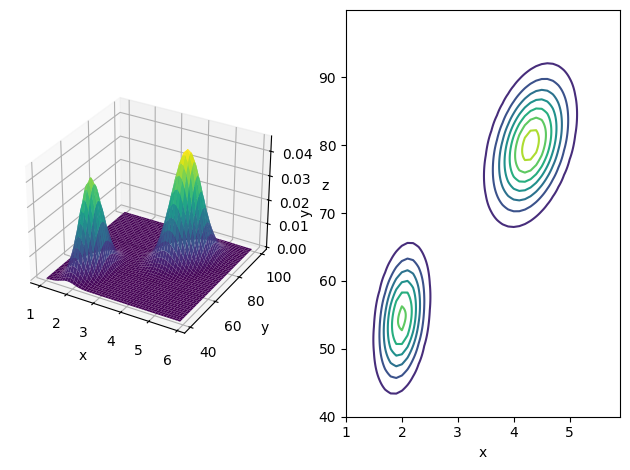

In [9]:
# x축과 y축의 범위 설정
xs = np.arange(1, 6, 0.1)  # x축: 1부터 6까지 0.1 간격
ys = np.arange(40, 100, 0.1)  # y축: 40부터 100까지 0.1 간격
X, Y = np.meshgrid(xs, ys)  # 2차원 격자 생성
Z = np.zeros_like(X)  # 확률밀도값을 저장할 배열 초기화

# 각 격자점에서 GMM의 확률밀도 계산
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        x = np.array([X[i, j], Y[i, j]])  # 현재 격자점의 좌표
        Z[i, j] = gmm(x, phis, mus, covs)  # GMM 확률밀도 계산

# 그래프 생성
fig = plt.figure()
# 3D 서피스 플롯
ax1 = fig.add_subplot(1, 2, 1, projection='3d')  # 1x2 그리드의 첫 번째 위치에 3D 플롯
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.plot_surface(X, Y, Z, cmap='viridis')  # 3D 서피스 플롯 생성

# 등고선 플롯
ax2 = fig.add_subplot(1, 2, 2)  # 1x2 그리드의 두 번째 위치에 2D 플롯
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.contour(X, Y, Z)  # 등고선 플롯 생성
plt.tight_layout()  # 서브플롯 간격 자동 조정
plt.show()  # 그래프 표시

---

## **4.4 GMM 매개변수 추정의 어려움**  

- **GMM의 핵심 과제 중 하나는 매개변수(평균, 공분산, 혼합 비율)를 정확히 추정하는 것**.  
- 그러나 **이 문제는 단순하지 않으며, 쉽게 해결되지 않음**.  
- 이번 절에서는 **GMM의 매개변수 추정이 왜 어려운지 수식적으로 분석**.

---

### **4.4.1 GMM의 매개변수 추정**  

GMM은 여러 개의 정규 분포를 가중합하여 표현:  

$p(x; \phi, \mu, \Sigma) = \sum_{k=1}^{K} \phi_k \mathcal{N}(x; \mu_k, \Sigma_k)$  [식 4.3]

- $ \phi_k $ : 각 정규 분포의 가중치 (혼합 계수)  
- $ \mu_k $, $ \Sigma_k $ : $ k $ 번째 정규 분포의 평균과 공분산 행렬  


샘플 데이터 $ D = \{ x^{(1)}, x^{(2)}, ..., x^{(N)} \} $ 가 주어졌을 때, 전체 가능도:  

$p(D; \theta) = \prod_{n=1}^{N} p(x^{(n)}; \theta)$  

- 여기서 $ \theta = \{\phi, \mu, \Sigma\} $ 는 GMM의 매개변수 집합.  

로그 변환하여 로그 가능도(Log-Likelihood)로 변환하면:  

$\log p(D; \theta) = \sum_{n=1}^{N} \log \left( \sum_{k=1}^{K} \phi_k N(x^{(n)}; \mu_k, \Sigma_k) \right)$  [식 4.4]

최대 가능도 추정을 위해 로그 가능도 $ L(\theta) = \log p(D; \theta) $ 를 최적화하는 방정식:  

$\frac{\partial L}{\partial \phi} = 0, \quad \frac{\partial L}{\partial \mu} = 0, \quad \frac{\partial L}{\partial \Sigma} = 0$  

- 그러나 **이 방정식은 해석적으로 풀 수 없음**.  
- 이유: **로그-합(log-sum) 형태**로 되어 있어 직접 풀기 어려움.  
- **합-로그(sum-log) 형태라면 쉽게 풀 수 있지만, GMM에서는 불가능함.**  

>**NOTE**  
>
>✅ **GMM에서 로그 가능도를 최적화하는 것이 어려운 이유**  
>
>- 예를 들어 **$ K = 1 $** (즉, 단일 정규 분포)라면,  
>  - 정규 분포는 **$ \exp(\cdot) $ 형태**이므로 **$ \log p(x) $** 를 해석적으로 최적화 가능.  
>- 그러나 **$ K \geq 2 $** (두 개 이상의 정규 분포)에서는  
>  - **$ \log \sum $ 형태**가 되어 수식이 복잡해짐 → **해석적으로 풀 수 없음.**  


**해결 방법 – EM 알고리즘(Expectation-Maximization)**  
    - GMM의 매개변수 추정을 위해 **EM 알고리즘(기댓값-최대화 알고리즘)이 사용됨**.  
    - **잠재 변수(latent variable) $ z $ 가 존재하는 문제에 적합한 알고리즘**.  
    - **로그 가능도를 최적화하는 방식으로 매개변수를 효율적으로 추정**.  
    - EM 알고리즘에 대한 자세한 내용은 이후 절에서 다룸.  

---

**로그-합(log-sum)과 합-로그(sum-log)의 차이**

1. **수식 형태**
- 로그-합(log-sum): $\log(a + b)$
- 합-로그(sum-log): $\log(a) + \log(b)$

2. **GMM에서의 예시**
- GMM의 로그 가능도는 로그-합 형태입니다:
```
로그-합 형태:
log(φ₁N(x; μ₁, Σ₁) + φ₂N(x; μ₂, Σ₂))
```

- 만약 합-로그 형태였다면:
```
합-로그 형태:
log(φ₁N(x; μ₁, Σ₁)) + log(φ₂N(x; μ₂, Σ₂))
```

3. **왜 차이가 생기나요?**
- **합-로그 형태**:
  - 로그의 성질 $\log(ab) = \log(a) + \log(b)$ 을 사용할 수 있음
  - 각 항을 독립적으로 미분 가능
  - 최적화가 쉬움

- **로그-합 형태**:
  - 로그 안에 있는 합을 분리할 수 없음
  - 미분 시 복잡한 연쇄 법칙이 필요
  - 최적화가 어려움

4. **실제 예시**

```python
# 합-로그는 쉽게 계산 가능
log(a) + log(b) = log(2) + log(3) = log(2) + log(3)

# 로그-합은 복잡
log(a + b) = log(2 + 3) ≠ log(2) + log(3)
```

이것이 GMM의 매개변수 추정이 어려운 주요 이유이며, 이를 해결하기 위해 EM 알고리즘과 같은 특별한 방법이 필요한 것입니다.

---

### Reference
- https://github.com/WegraLee/deep-learning-from-scratch-5
- https://github.com/restful3/ds4th_study/blob/main/source/%EB%B0%91%EB%B0%94%EB%8B%A5%EB%B6%80%ED%84%B0_%EC%8B%9C%EC%9E%91%ED%95%98%EB%8A%94_%EB%94%A5%EB%9F%AC%EB%8B%9D_5/step04_%EA%B0%80%EC%9A%B0%EC%8A%A4_%ED%98%BC%ED%95%A9_%EB%AA%A8%EB%8D%B8_song.ipynb